# 01_Forest_Fire_Tree_Outcomes_EDA

This project will build on a recently published dataset (published today, actually).

**The Fire and Tree Mortality Database, for empirical modeling of individual tree mortality after fire** by C. Alina Cansler et al., published 22 June 2020.

Cansler, C.A., Hood, S.M., Varner, J.M. et al. The Fire and Tree Mortality Database, for empirical modeling of individual tree mortality after fire. Sci Data 7, 194 (2020). https://doi.org/10.1038/s41597-020-0522-7



Developing a model that can predict tree recovery based on measured damage to a tree after a fire can help determine the best course of action when considering how to address partially burned trees in parks or on private land.
 
In addition, this data can be combined with other forest and meteorological information to extend the types of predictions and inferences we can make around forest fires.

*Note: The authors have abbreviated this data base as "FTM"; this notebook will do the same.*


## Contents

1. Project goals and constraints
2. Data gathering
3. Explore the primary fire and tree data
4. Explore secondary data sets
5. Summary



# 1. Project goals and constraints

Goals: 
- Build a model to predict the survival of a tree based on damage sustained in a fire.
- Examine the primary contributors to the success of the model, and compare to published model results (see Cansler)

Evaluation:
- TBD - expect to start with linear or logistical regression predicting the number of years of survival (need to finish more EDA on this and other sources first)
- TBD - may try to replicate the work of previous models, in which case I'll use their metrics for comparison (need to read those papers first, though)
- TBD - if I can get to the next level, which is to show that there is additional data that has predictive power (or "identify knowledge gaps that could be addressed in future research", as Cansler says) then I may add more 

Value: 
- Models for tree survival are used by forest and land management, possibly by homeowners
- Cansler: "pre-fire planning and post-fire decision support"

Time Frame: 
- A functioning model will be completed by 9 July 2020.
- If time permits this will be extedned to include other data sources and insights. See the 'Roadmap' in the Summary section for where the expanding and contracting of focus will occur.

## Proposed methods and models
* **Methods**
  * EDA on core data; identification of supporting data
  * Think outside the boxwood and do something clever
* **Models under consideration**
  * PCA, t-SNE
  * DecisionTree is required for obvious reasons
  * Replicate the models built by others but using this much fuller dataset

## Risks & Assumptions

|ID|Description|Possible Migitation(s)|
|---|---|---|
|1|Kaggle|Make my project better than theirs.|
|2|||

## Revisions

There are no revisions yet. 

# 2. Data gathering

The central data comes from the 2020-06-22 publication of **The Fire and Tree Mortality Database, for empirical modeling of individual tree mortality after fire** by Cansler et al., which is in turn a collection of data from 41 other datasets, some of which were compilations already.

By the end of this project, it is likely that I will have combined this with a couple of other datasets

|Dataset Code|Dataset Name|Source|Link|Notes||
|---|---|---|---|---|---|
|FTM|**Fire and Tree Mortality Database**|nature.com datasets|https://www.nature.com/articles/s41597-020-0522-7|Burn extent and 0-to-10 year outcomes for 160k+ trees||
||Forest Fires Data Set|UCI, also Kaggle| https://archive.ics.uci.edu/ml/datasets/forest+fires|Dataset intended for predicting forest fires from weather conditions; I would use it to see if there is a correlation between pre-fire weather to tree outcomes post-fire||
||TBD|TBD|TBD|Weather conditions in the weeks and years following the fire||
||TBD|TBD|TBD|Satellite photos over the relevant years, possibly extending beyond the 10 years in the database||

# 3. Explore the primary fire and tree data (Cansler et al.)

## 3a. Imports and Globals

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

In [2]:
# Global options to increase rows and columns displayed
pd.set_option('display.max_columns', None)
# pd.reset_option(“max_columns”) # to reset back to limited columns

pd.set_option("max_rows", None)

In [3]:
!ls ../data_ftm

Dataset_citations.csv        FTM_trees.csv
Dataset_primary_contacts.csv Species_BarkThickness.csv
FTM_fires.csv


In [4]:
fname_trees = '../data_ftm/FTM_trees.csv'
fname_fires = '../data_ftm/FTM_fires.csv'

In [5]:
df_trees = pd.read_csv(fname_trees, low_memory=False)
# issue on import:
#/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: 
# Columns (4,5,6,7,10,62,63) have mixed types.Specify dtype option on import or set low_memory=False.
# interactivity=interactivity, compiler=compiler, result=result)


# NOTE: this is run on a MacBook Pro with 32 GB memory; others may need to adjust this. 171k observations...

In [6]:
df_fires = pd.read_csv(fname_fires)

In [7]:
print(f"shape of trees: {df_trees.shape}")
print(f"shape of fires: {df_fires.shape}")

num_trees = df_trees.shape[0]

shape of trees: (170963, 64)
shape of fires: (416, 16)


## 3b. Trees

In [8]:
# Peek at the dataframe
df_trees.head(3)

,YrFireName,Species,Dataset,Times_burned,ID,Plot,TreeNum,Unit,Genus,Species_name,Subspecies,Genus_species,DBH_cm,DRC_cm,HT_m,HCB_pre,CR_pre,CC,VR,CL_m,yr0status,yr1status,yr2status,yr3status,yr4status,yr5status,yr6status,yr7status,yr8status,yr9status,yr10status,HCB_post,CR_post,CSH_m,CLS_m,CLK_m,CLS_percent,CLK_percent,CVS_percent,CVK_percent,CVC_percent,CBS,BCHA_m,BCHM_m,BCH_percent,BCA,CKR,GCA,GIR_percent,DMR,BTL,AB,DFB,FEN,IPS,MPB,RPB,RTB,SB,WPB,WB,SPB,CVS_percent_source,CVK_percent_source
0,2006 - Tripod,2TREE,Prichard,1,NaN,188,15,NaN,NaN,NaN,NaN,Unknown,26.416,NaN,21.03,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,21.03,21.03,100.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
1,2006 - Tripod,2TREE,Prichard,1,NaN,74,20,NaN,NaN,NaN,NaN,Unknown,1.270,NaN,2.13,1.52,0.29,NaN,NaN,0.61,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,0.61,0.61,29.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
2,2006 - Tripod,2TREE,Prichard,1,NaN,193,22,NaN,NaN,NaN,NaN,Unknown,25.400,NaN,18.29,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,18.29,18.29,100.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN


**Data Dictionary**

From the file _metadata_RDS-2020-0001.html

|Feature|Description|NA means|Notes|
|---|---|---|---|
|YrFireName|A unique identifier for each fire event that includes the year of the fire and the fire name; YEAR - Fire|||
|Species|Symbol for species. First two letters of genus and first two letters of species, sometimes followed by a number. Symbols follow those in the PLANTS National Database (http://plants.usda.gov). |2TREE = unknown tree species.||
|Dataset|The name of the subset of data that was contributed to the Fire and Tree Mortality (FTM) project. This is typically the name of the person who contributed the data to the FTM project but may be the agency that is the primary data steward.|||
|Times_burned|number of times this tree was burned|||
|ID|Location within fire other than the plot number that is a location identifier in the original dataset. May include burn unit, region of fire, etc. |NA = not applicable.||
|Plot|Plot number/name from original dataset. |NA = not applicable.||
|TreeNum|Tree tag number from original dataset. |NA = tree numbers were not assessed in the original dataset.||
|Unit|Unit name within a fire from original dataset.|NA = not applicable.||
|Genus|Genus of species.|NA = species not assessed in original dataset.||
|Species_name|Specific epithet.|NA = species not assessed in original dataset.||
|Subspecies|Subspecies or variety.|NA = subspecies not assessed. Symbols follow those in the PLANTS National Database (http://plants.usda.gov).||
|Genus_species|Genus and species of tree.|||
|DBH_cm|Diameter at breast height rounded to nearest 0.1 cm (cm = centimeters).|NA = not assessed.||
|DRC_cm|Diameter at root crown rounded to nearest 0.1 cm (cm = centimeters). |NA = not assessed.||
|HT_m|Pre-fire tree height rounded to nearest 0.01 m (m=meters).|NA = not assessed.||
|HCB_pre|Pre-fire height of the base of the live crown rounded to nearest 0.01 m (m=meters).|NA = not assessed; HCB_pre not measured.||
|CR_pre|Pre-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01).|NA = not assessed.||
|CC|Canopy class for trees (1 = dominant, 2 = codominant, 3 = intermediate, 4 = suppressed).|NA = not assessed.||
|VR|Vigor rating for trees (1 = healthy, 2 = unhealthy, 3 = dying).|NA = not assessed.||
|CL_m|Pre-fire live crown length rounded to nearest 0.01 m (m=meters).|NA = not assessed; CL_m not measured.||
|yr0status|Tree status the year the fire occurred, after the fire occurred (0=alive, 1=dead).|NA= not assessed in timestep.||
|yr1status|Tree status in year 1 post-fire. (0=alive, 1=dead). Counted in growing seasons − if fire occurred in spring prior to bud break, 1 year post-fire is that same year as fire. If fire occurred during growing season or fall, 1 year post-fire is the next calendar year after fire.|||
|yr2status|Tree status in year 2 post-fire. (0=alive, 1=dead). Counted in growing seasons − if fire occurred in spring prior to bud break, 1 year post-fire is that same year as fire. If fire occurred during growing season or fall, 1 year post-fire is the next calendar year after fire.|||
|yrNstatus|...data by year is available for years 1 through 10...|||
|yrNstatus|...data by year is available for years 1 through 10...|||
|yr10status|Tree status in year 10 post-fire. (0=alive, 1=dead). Counted in growing seasons − if fire occurred in spring prior to bud break, 1 year post-fire is that same year as fire. If fire occurred during growing season or fall, 1 year post-fire is the next calendar year after fire.|||
|HCB_post|Post-fire height to live crown base rounded to nearest 0.01 m (m=meters).|NA = not assessed.||
|CR_post|Post-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01).|NA = not assessed.||
|CSH_m|Height of crown scorch, assessed as the highest visible heat injury to leaves from ground level, rounded to nearest 0.01 m (m = meters). Includes scorched and consumed portions of the crown.|NA = not assessed.||
|CLS_m|Length of the pre-fire crown that was scorched or consumed by fire rounded to nearest 0.01 m (m = meters). NA = not assessed. In some cases this was a direct measurement in the field, and in others it was calculated using other measurements, including tree height, scorch height, pre-fire and post-fire height to canopy base, or pre-fire and post-fire crown ratio.|||
|CLK_m|Length of the pre-fire crown that fire killed tree buds by either scorch or consumption, rounded to nearest 0.01 m (m= meters). The tree’s buds are meristematic tissue that develops into branches, flowers, or leaves; usually at the end of stems, branches, and foliage. Should be equal to or less than crown length scorched (CLS_m). CLK_m and CLS_m typically only differ for species with protected buds (e.g., ponderosa pine, longleaf pine). |NA = not assessed.||
|CLS_percent|Percent of the pre-fire crown length that was scorched or consumed by fire rounded to nearest 1 percent (values 0 to 100).  In some cases this was a direct measurement in the field, an in others it was calculated using other measurments, including tree height, scorch height, pre-fire and post-fire height to canopy base, or pre-fire and post-fire crown ratio.|NA = not assessed.||
|CLK_percent|Percentage of the pre-fire crown that was scorched with bud kill or consumed by fire rounded to nearest 1 percent (values 0 to 100). The tree’s buds are meristematic tissue that develops into branches, flowers, or leaves; usually at the end of stems, branches, and foliage. Should be equal to or less than CLS_percent. CLK_percent and CLS_percent typically only differ for species with protected buds (e.g., ponderosa pine, longleaf pine). In some cases this was a direct measurement in the field, an in others it was calculated using other measurments, including tree height, kill height, pre-fire and post-fire height to canopy base, or pre-fire and post-fire crown ratio.|NA = not assessed. ||
|CVS_percent|Percent of the pre-fire crown volume that was scorched or consumed by fire (values 0 to 100). If measured, this is the CVS from field measurements. Otherwise it is the calculated CVS from crown length measurement, where CVS=100[(CLS(2CL_pre - CLS))/CL_pre2].|NA = not assessed.||
|CVK_percent|Percentage of pre-fire crown volume killed by fire (values 0 to 100). Should always be less than percent of pre-fire crown volume scorched. If measured, this is the CVS from field measurements. Otherwise it is the calculated CVS from crown length measurement, where CVK=100[(CLK(2CL_pre - CLK))/CL_pre2].|NA = not assessed.||
|CVC_percent|Percent canopy volume consumed, or blackened, by the fire (values 0 to 100).|NA = not assessed.||
|CBS|Percent circumference of the bole scorch (values 0 to 100). In some studies this was measured as the maximum percent of tree circumference burned, at any height, and in others this was considered at ground-level. Refer to database related citation for additional information.|NA = not assessed.||
|BCHA_m|Average bark char (also called bole char, bole scorch in other publications) vertical height from ground on a tree bole, rounded to nearest 0.01 m (m=meters).|NA = not assessed.||
|BCHM_m|Maximum bark char (also called bole char, bole scorch in other publications) vertical height from ground on a tree bole, rounded to nearest 0.01 m (m=meters).|NA = not assessed.||
|BCH_percent|Percent of tree height blackened or charred, calculated based on maximum bark char height (values 0 to 100).|NA = not assessed.||
|BCA|Average bark char (also called bole char, bole scorch in other publications) rating; a classification system used as a proxy for the duration a tree bole was exposed to heating by fire. Bark char code was assessed in four quadrants at the base of the tree and the then averaged. Codes: 0=unburned, 1=light, 2=moderate, and 3=deep. For more information see: Hood, S. M., D. R. Cluck, S. L. Smith, and K. C. Ryan. 2008. Using bark char codes to predict post-fire cambium mortality. Fire Ecology 4:57-73.|NA = not assessed.||
|CKR|Cambium kill rating. Four quadrants on each tree were assessed for cambium status. CKR is the number of quadrants with dead cambium at ground line; a value between 0-4; requires removing a small sample of bark at four locations at a tree’s base. A small number of observations only had 3 quadrants assessed. In this case, CKR was calculated by summing the number of quadrants with dead cambium, dividing the sum by number of quadrants measured, and then multiplying by 4.|NA = not assessed.||
|GCA|Average ground char rating. Four quadrants around each tree for soil heating severity, where 1= light ground char, 2= moderate ground char, and 3 = heavy ground char (has also been called deep ground char). The four ratings were averaged into one value of GCA. For more information see: Ryan, K. C., and N. V. Noste. 1985. Evaluating prescribed fires. Pages 230-238 in J. Lotan, B. M. Kilgore, W. C. Fischer, and R. W. Mutch, editors. Proceedings - symposium and workshop on wilderness fire. Missoula, MT, 15-18 November 1983. Gen. Tech. Rep. INT-182. U.S. Department of Agriculture, Forest Service, Intermountain Forest and Range Experiment Station, Ogden, UT.|NA = not assessed.||
|GIR_percent|Estimated percent of tree girdled from heating at ground line (values = 0 to 100).|NA = not assessed.||
|DMR|Dwarf mistletoe rating; follows Hawksworth 0 - 6 scale. Hawksworth, F. G. 1977. The 6-class dwarf mistletoe rating system. GTR-RM-48. U.S. Department of Agriculture, Forest Service, Rocky Mountain Forest and Range Experiment Station, Fort Collins, CO.|NA = not assessed.||
|BTL|Presence or absence (presence=1, absence=0) of primary beetle species that can cause mortality of healthy trees. Species include Dendroctonus ponderosae, D. frontalis, D. adjunctus, D. brevicomis, D. frontalis, D. pseudotsugae, and D. rufipennis.|NA = not assessed.||
|AB|Ambrosia beetle presence or absence; Trypodendron sp., Gnathotrichus sp., Xyleborus sp. [Curculionidae: Scolytinae], Platypus sp. [Curculionidae: Platypodidae] (presence=1, absence=0).|NA = not assessed.||
|DFB|Douglas-fir beetle presence or absence; Dendroctonus pseudotsugae; (presence=1, absence=0).|NA = not assessed.||
|FEN|Fir engraver beetle presence or absence; Scolytus ventralis; (presence=1, absence=0).|NA = not assessed.||
|IPS|Ips beetle presence or absence; Coleoptera and Scolytidae; (presence=1, absence=0).|NA = not assessed.||
|MPB|Mountain pine beetle presence or absence; Dendroctonus ponderosae; (presence=1, absence=0).|NA = not assessed.||
|RPB|Roundheaded pine beetle presence or absence; Dendroctonus adjunctus (presence=1, absence=0).|NA = not assessed.||
|RTB|Red turpentine beetle presence or absence; Dendroctonus valens (presence=1, absence=0).|NA = not assessed.||
|SB|Spruce beetle presence or absence; Dendroctonus rufipennis (presence=1, absence=0).|NA = not assessed.||
|WPB|Western pine beetle presence or absence; Dendroctonus brevicomis (presence=1, absence=0).|NA = not assessed.||
|WB|Woodborers presence or absence; Buprestidae and Cerambycidae; (presence=1, absence=0).|NA = not assessed.||
|SPB|Southern pine beetle presence or absence; Dendroctonus frontalis (presence=1, absence=0).|NA = not assessed.||
|CVS_percent_source|Denotes whether directly assessed in the field or calculated as described in FOFEM help document (F=field; C=calculated).|NA = not assessed.||
|CVK_percent_source|Denotes whether directly assessed in the field or calculated as described in FOFEM help document. F= field; C=calculated.|NA = not assessed.||

In [9]:
# A few handy feature collections
features_key = ['YrFireName','Genus_species']
features_parasites = ['BTL', 'AB', 'DFB', 'FEN', 'IPS', 'MPB',
       'RPB', 'RTB', 'SB', 'WPB', 'WB', 'SPB']
features_years = ['yr0status', 'yr1status', 'yr2status', 'yr3status',
       'yr4status', 'yr5status', 'yr6status', 'yr7status', 'yr8status',
       'yr9status', 'yr10status']

In [10]:
# Over 11_000 trees in the biggest single fire
df_trees['YrFireName'].value_counts().head(3)

2008 - New Fork      11131
2006 - Tripod         8868
2012 - Pole Creek     4947
Name: YrFireName, dtype: int64

In [11]:
# Some fires, or fire sections, include only 1 tree
df_trees['YrFireName'].value_counts().tail(3)

1999 - GRCA Shoshone                          1
1999 - BAND 38                                1
1995 - LABE Eagles Nest_Callahan_Big Nasty    1
Name: YrFireName, dtype: int64

In [13]:
df_trees.info()
# Most of these make sense; need to investigate a couple
# Plot, TreeNum, Unit
# CVS_percent_source, CVK_percent_source

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170963 entries, 0 to 170962
Data columns (total 64 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   YrFireName          170963 non-null  object 
 1   Species             170963 non-null  object 
 2   Dataset             170963 non-null  object 
 3   Times_burned        170963 non-null  int64  
 4   ID                  55657 non-null   object 
 5   Plot                144760 non-null  object 
 6   TreeNum             143789 non-null  object 
 7   Unit                55303 non-null   object 
 8   Genus               170463 non-null  object 
 9   Species_name        169466 non-null  object 
 10  Subspecies          19523 non-null   object 
 11  Genus_species       170963 non-null  object 
 12  DBH_cm              166925 non-null  float64
 13  DRC_cm              1359 non-null    float64
 14  HT_m                109527 non-null  float64
 15  HCB_pre             81575 non-null

In [14]:
# df_trees['Plot'].nunique()
# 2470 unique...that's too many to scan all at once
# Seems like these should be integers...peek through
df_trees['Plot'].value_counts().head(8) 
# Turns out that some of them are string...so this will remain an object

1           14689
2            3918
3            3630
YOHOPIPO     3218
4            2886
5            1946
CRCRPIPO     1518
6            1455
Name: Plot, dtype: int64

In [15]:
df_trees['TreeNum'].value_counts().tail(10)
# These look like possible Plot names...check to see if there's an import error

SEKI_B:FSEGI1T08:075_283    1
7250000                     1
37880000                    1
612_3384                    1
CRLA_FPICO2D08-03_871       1
WHIS_FQUKE1D0909_1388       1
5509                        1
GRCA_PIPN 24_39             1
7695                        1
810000                      1
Name: TreeNum, dtype: int64

In [16]:
df_trees.loc[df_trees['TreeNum'] == 'BAND_FPIPO2T0902_2139',:]  # looks a little suspicious; check this fire

,YrFireName,Species,Dataset,Times_burned,ID,Plot,TreeNum,Unit,Genus,Species_name,Subspecies,Genus_species,DBH_cm,DRC_cm,HT_m,HCB_pre,CR_pre,CC,VR,CL_m,yr0status,yr1status,yr2status,yr3status,yr4status,yr5status,yr6status,yr7status,yr8status,yr9status,yr10status,HCB_post,CR_post,CSH_m,CLS_m,CLK_m,CLS_percent,CLK_percent,CVS_percent,CVK_percent,CVC_percent,CBS,BCHA_m,BCHM_m,BCH_percent,BCA,CKR,GCA,GIR_percent,DMR,BTL,AB,DFB,FEN,IPS,MPB,RPB,RTB,SB,WPB,WB,SPB,CVS_percent_source,CVK_percent_source
118038,1994 - BAND 14,PIPO,NPS,1,FPIPO2T0902,NaN,BAND_FPIPO2T0902_2139,NaN,Pinus,ponderosa,NaN,Pinus_ponderosa,25.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN


In [17]:
df_trees.loc[df_trees['YrFireName']=='1994 - BAND 14']
# Possible error in the *.csv file where the TreeNum was merged with the Plot name;
#   if this turns out to be important, either check the original source or contact the author

,YrFireName,Species,Dataset,Times_burned,ID,Plot,TreeNum,Unit,Genus,Species_name,Subspecies,Genus_species,DBH_cm,DRC_cm,HT_m,HCB_pre,CR_pre,CC,VR,CL_m,yr0status,yr1status,yr2status,yr3status,yr4status,yr5status,yr6status,yr7status,yr8status,yr9status,yr10status,HCB_post,CR_post,CSH_m,CLS_m,CLK_m,CLS_percent,CLK_percent,CVS_percent,CVK_percent,CVC_percent,CBS,BCHA_m,BCHM_m,BCH_percent,BCA,CKR,GCA,GIR_percent,DMR,BTL,AB,DFB,FEN,IPS,MPB,RPB,RTB,SB,WPB,WB,SPB,CVS_percent_source,CVK_percent_source
13350,1994 - BAND 14,ABCO,NPS,1,FPIPO2T0902,NaN,BAND_FPIPO2T0902_2489,NaN,Abies,concolor,NaN,Abies_concolor,29.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
117974,1994 - BAND 14,PIPO,NPS,1,FPIPO2T0901,NaN,BAND_FPIPO2T0901_2214,NaN,Pinus,ponderosa,NaN,Pinus_ponderosa,38.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,1.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
117975,1994 - BAND 14,PIPO,NPS,1,FPIPO2T0901,NaN,BAND_FPIPO2T0901_2216,NaN,Pinus,ponderosa,NaN,Pinus_ponderosa,17.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
117976,1994 - BAND 14,PIPO,NPS,1,FPIPO2T0901,NaN,BAND_FPIPO2T0901_2218,NaN,Pinus,ponderosa,NaN,Pinus_ponderosa,15.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,NaN,NaN,NaN,NaN,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
117977,1994 - BAND 14,PIPO,NPS,1,FPIPO2T0901,NaN,BAND_FPIPO2T0901_2220,NaN,Pinus,ponderosa,NaN,Pinus_ponderosa,19.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
117978,1994 - BAND 14,PIPO,NPS,1,FPIPO2T0901,NaN,BAND_FPIPO2T0901_2221,NaN,Pinus,ponderosa,NaN,Pinus_ponderosa,20.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.0,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
117979,1994 - BAND 14,PIPO,NPS,1,FPIPO2T0901,NaN,BAND_FPIPO2T0901_2222,NaN,Pinus,ponderosa,NaN,Pinus_ponderosa,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
117980,1994 - BAND 14,PIPO,NPS,1,FPIPO2T0901,NaN,BAND_FPIPO2T0901_2224,NaN,Pinus,ponderosa,NaN,Pinus_ponderosa,19.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.0,NaN,NaN,NaN,NaN,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
117981,1994 - BAND 14,PIPO,NPS,1,FPIPO2T0901,NaN,BAND_FPIPO2T0901_2226,NaN,Pinus,ponderosa,NaN,Pinus_ponderosa,29.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0,NaN,NaN,NaN,NaN,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
117982,1994 - BAND 14,PIPO,NPS,1,FPIPO2T0901,NaN,BAND_FPIPO2T0901_2228,NaN,Pinus,ponderosa,NaN,Pinus_ponderosa,21.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN


In [18]:
df_trees['CVS_percent_source'].value_counts() # These represent Field and Calculated; just an odd name

F    104995
C     20758
Name: CVS_percent_source, dtype: int64

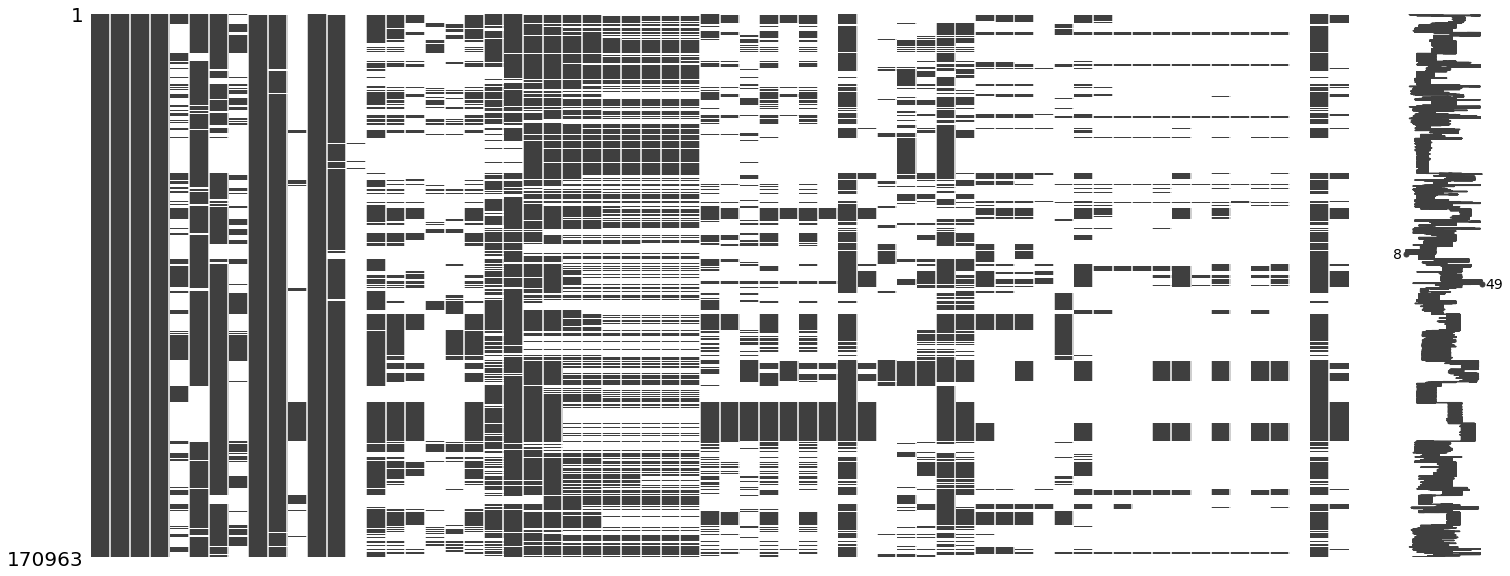

In [19]:
# Too many features to see what's happening...but there's a lot of data missing in the later columns like 
#      beetle kill
msno.matrix(df_trees)

In [20]:
df_trees.info()
# need to consider which columns to use, then possibly drop rows with data missing
# unclear why there are missing values for the yearly outcomes, perhaps we can infer 
#     alive prior to the first 1 or
#     dead after the last 0?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170963 entries, 0 to 170962
Data columns (total 64 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   YrFireName          170963 non-null  object 
 1   Species             170963 non-null  object 
 2   Dataset             170963 non-null  object 
 3   Times_burned        170963 non-null  int64  
 4   ID                  55657 non-null   object 
 5   Plot                144760 non-null  object 
 6   TreeNum             143789 non-null  object 
 7   Unit                55303 non-null   object 
 8   Genus               170463 non-null  object 
 9   Species_name        169466 non-null  object 
 10  Subspecies          19523 non-null   object 
 11  Genus_species       170963 non-null  object 
 12  DBH_cm              166925 non-null  float64
 13  DRC_cm              1359 non-null    float64
 14  HT_m                109527 non-null  float64
 15  HCB_pre             81575 non-null

## Address the missing outcomes values

In [21]:
df_trees['yr0status'].isnull().sum() # 57_204 null values for year 0

57204

In [22]:
# Make a few masks to explore this
mask_yr0 = df_trees['yr0status'].isnull()
mask_yr1 = df_trees['yr1status'].isnull()
mask_yr2 = df_trees['yr2status'].isnull()
mask_yr3 = df_trees['yr3status'].isnull()
mask_yr4 = df_trees['yr4status'].isnull()
mask_yr5 = df_trees['yr5status'].isnull()
mask_yr6 = df_trees['yr6status'].isnull()
mask_yr7 = df_trees['yr7status'].isnull()
mask_yr8 = df_trees['yr8status'].isnull()
mask_yr9 = df_trees['yr9status'].isnull()
mask_yr10 = df_trees['yr10status'].isnull()

mask_no_years = mask_yr0 & mask_yr1 & mask_yr2 & mask_yr3 & mask_yr4 & mask_yr5 & mask_yr6 & mask_yr7 & \
            mask_yr8 & mask_yr9 & mask_yr10


In [23]:
df_trees.loc[mask_no_years,:]['YrFireName'].count() # 2888 have no data on outcomes; drop those

2888

In [24]:
print(f"Observations before: {df_trees.shape[0]}")
df_trees.drop(df_trees.loc[mask_no_years,:].index,inplace=True)
print(f"Observations after:  {df_trees.shape[0]}")

Observations before: 170963
Observations after:  168075


In [25]:
df_trees.loc[(mask_yr0 & (mask_yr1)),:]['YrFireName'].count() 
# 18_016 trees with years 0 and 1 NA? wow

18016

**Discussion**

- Some trees have NA for the first 2 years, then alive. In some of the metadata, the comment was made that some species will regrow from shoots. I can't throw this data out until I've investigated whether "shoots" could be implied.
- Some trees have NA for all of the years, plus for other variables. Here are some datasets where this is the case, such as "2002 - Southeastern Piedmont Clemson SC 77". Since the alive/dead after N years is the predicted variable here, these 2_888 were dropped.


In [26]:
# See if some of these fires have too little data and need to be tossed for my purposes
df_trees.loc[df_trees['YrFireName']=="2002 - Southeastern Piedmont Clemson SC 77",:]['YrFireName'].count()

233

In [27]:
df_trees.loc[df_trees['YrFireName']=="2002 - Southeastern Piedmont Clemson SC 77",:].head(2)


,YrFireName,Species,Dataset,Times_burned,ID,Plot,TreeNum,Unit,Genus,Species_name,Subspecies,Genus_species,DBH_cm,DRC_cm,HT_m,HCB_pre,CR_pre,CC,VR,CL_m,yr0status,yr1status,yr2status,yr3status,yr4status,yr5status,yr6status,yr7status,yr8status,yr9status,yr10status,HCB_post,CR_post,CSH_m,CLS_m,CLK_m,CLS_percent,CLK_percent,CVS_percent,CVK_percent,CVC_percent,CBS,BCHA_m,BCHM_m,BCH_percent,BCA,CKR,GCA,GIR_percent,DMR,BTL,AB,DFB,FEN,IPS,MPB,RPB,RTB,SB,WPB,WB,SPB,CVS_percent_source,CVK_percent_source
24838,2002 - Southeastern Piedmont Clemson SC 77,ACRU,McIver,2,NaN,744,544,R2TB-CLM_thin-burn,Acer,rubrum,NaN,Acer_rubrum,10.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24840,2002 - Southeastern Piedmont Clemson SC 77,ACRU,McIver,2,NaN,750,235,R2TB-CLM_thin-burn,Acer,rubrum,NaN,Acer_rubrum,11.3,NaN,10.7,4.6,NaN,4.0,1.0,6.1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.6,NaN,NaN,3.0,NaN,49.0,NaN,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN


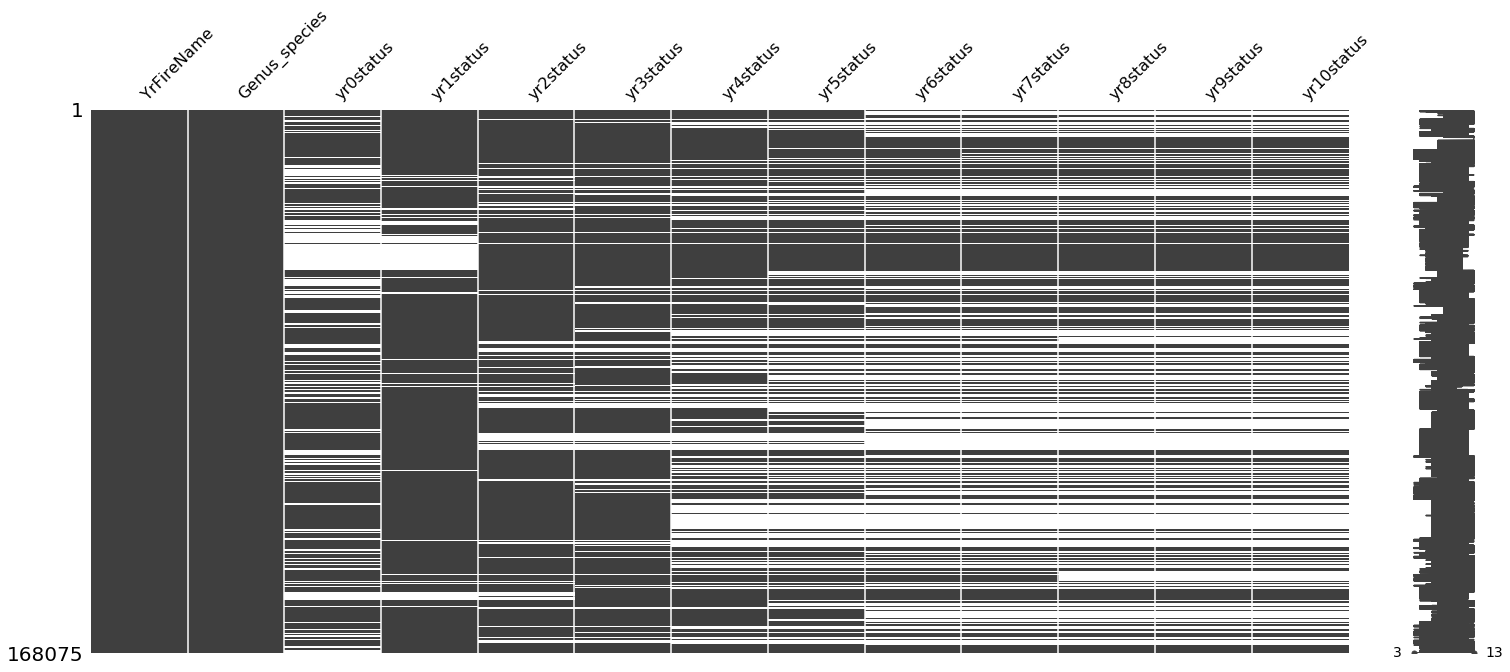

In [28]:
# check key missing items
msno.matrix(df_trees[features_key + features_years])

In [29]:
#df_trees.loc[168060:168070,features_key+features_years]
df_trees.loc[168000:168060,features_key+features_years]

,YrFireName,Genus_species,yr0status,yr1status,yr2status,yr3status,yr4status,yr5status,yr6status,yr7status,yr8status,yr9status,yr10status
168000,2015 - Tower,Thuja_plicata,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
168001,2015 - Tower,Thuja_plicata,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
168002,2015 - Tower,Thuja_plicata,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
168003,2015 - Tower,Thuja_plicata,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
168004,2015 - Tower,Thuja_plicata,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168005,2015 - Tower,Thuja_plicata,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
168006,2015 - Tower,Thuja_plicata,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168007,2015 - Tower,Thuja_plicata,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
168008,2015 - Tower,Thuja_plicata,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
168009,2015 - Grizzly,Thuja_plicata,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [30]:
# Find some test cases to make sure the part below works
# rows 200, 202, 203 have NaN and then 1.0
# rows 24838, 24840 have yr0 as 0, then NaN after that


In [31]:
df_trees.loc[24838:24840,['YrFireName','yr0status','yr1status','yr2status','yr3status','yr4status']]

,YrFireName,yr0status,yr1status,yr2status,yr3status,yr4status
24838,2002 - Southeastern Piedmont Clemson SC 77,0.0,0.0,0.0,NaN,NaN
24840,2002 - Southeastern Piedmont Clemson SC 77,0.0,0.0,NaN,NaN,NaN


In [32]:
df_trees.loc[24838:24840,features_key+features_years]

,YrFireName,Genus_species,yr0status,yr1status,yr2status,yr3status,yr4status,yr5status,yr6status,yr7status,yr8status,yr9status,yr10status
24838,2002 - Southeastern Piedmont Clemson SC 77,Acer_rubrum,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24840,2002 - Southeastern Piedmont Clemson SC 77,Acer_rubrum,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df_trees.loc[200:205,features_key+features_years]

,YrFireName,Genus_species,yr0status,yr1status,yr2status,yr3status,yr4status,yr5status,yr6status,yr7status,yr8status,yr9status,yr10status
200,2008 - New Fork,Unknown,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
201,2008 - Gunbarrel,Unknown,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
202,2011 - Red Rock,Unknown,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
203,2008 - New Fork,Unknown,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
204,2008 - Gunbarrel,Unknown,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
205,2008 - New Fork,Unknown,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [35]:
# number of nulls before smart fill
df_trees[features_years].isnull().sum()

yr0status     54316
yr1status     20689
yr2status     30238
yr3status     31484
yr4status     57987
yr5status     65678
yr6status     80360
yr7status     80745
yr8status     83856
yr9status     83939
yr10status    84053
dtype: int64

In [36]:
# 0 = alive
# 1 = dead

# DECISION: If there is a 0.0 in any yrNstatus, mark all years before that as 0.0
# DECISION: If there is a 1.0 in any yrNstatus, mark all years after that as 1.0

# Work backwards first, fill alive
df_trees['yr9status'] = np.where(df_trees['yr10status']==0,0,df_trees['yr9status'])
df_trees['yr8status'] = np.where(df_trees['yr9status']==0, 0,df_trees['yr8status'])
df_trees['yr7status'] = np.where(df_trees['yr8status']==0, 0,df_trees['yr7status'])
df_trees['yr6status'] = np.where(df_trees['yr7status']==0, 0,df_trees['yr6status'])
df_trees['yr5status'] = np.where(df_trees['yr6status']==0, 0,df_trees['yr5status'])
df_trees['yr4status'] = np.where(df_trees['yr5status']==0, 0,df_trees['yr4status'])
df_trees['yr3status'] = np.where(df_trees['yr4status']==0, 0,df_trees['yr3status'])
df_trees['yr2status'] = np.where(df_trees['yr3status']==0, 0,df_trees['yr2status'])
df_trees['yr1status'] = np.where(df_trees['yr2status']==0, 0,df_trees['yr1status'])
df_trees['yr0status'] = np.where(df_trees['yr1status']==0, 0,df_trees['yr0status'])

In [37]:
df_trees.loc[200:205,features_key+features_years]

,YrFireName,Genus_species,yr0status,yr1status,yr2status,yr3status,yr4status,yr5status,yr6status,yr7status,yr8status,yr9status,yr10status
200,2008 - New Fork,Unknown,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
201,2008 - Gunbarrel,Unknown,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
202,2011 - Red Rock,Unknown,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
203,2008 - New Fork,Unknown,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
204,2008 - Gunbarrel,Unknown,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
205,2008 - New Fork,Unknown,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [38]:
# Work forwards next, fill dead
df_trees['yr1status'] = np.where(df_trees['yr0status']==1, 1,df_trees['yr1status'])
df_trees['yr2status'] = np.where(df_trees['yr1status']==1, 1,df_trees['yr2status'])
df_trees['yr3status'] = np.where(df_trees['yr2status']==1, 1,df_trees['yr3status'])
df_trees['yr4status'] = np.where(df_trees['yr3status']==1, 1,df_trees['yr4status'])
df_trees['yr5status'] = np.where(df_trees['yr4status']==1, 1,df_trees['yr5status'])
df_trees['yr6status'] = np.where(df_trees['yr5status']==1, 1,df_trees['yr6status'])
df_trees['yr7status'] = np.where(df_trees['yr6status']==1, 1,df_trees['yr7status'])
df_trees['yr8status'] = np.where(df_trees['yr7status']==1, 1,df_trees['yr8status'])
df_trees['yr9status'] = np.where(df_trees['yr8status']==1, 1,df_trees['yr9status'])
df_trees['yr10status'] = np.where(df_trees['yr9status']==1,1,df_trees['yr10status'])

In [39]:
df_trees.loc[24838:24840,features_key+features_years]

,YrFireName,Genus_species,yr0status,yr1status,yr2status,yr3status,yr4status,yr5status,yr6status,yr7status,yr8status,yr9status,yr10status
24838,2002 - Southeastern Piedmont Clemson SC 77,Acer_rubrum,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24840,2002 - Southeastern Piedmont Clemson SC 77,Acer_rubrum,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df_trees.loc[200:205,features_key+features_years]

,YrFireName,Genus_species,yr0status,yr1status,yr2status,yr3status,yr4status,yr5status,yr6status,yr7status,yr8status,yr9status,yr10status
200,2008 - New Fork,Unknown,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
201,2008 - Gunbarrel,Unknown,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
202,2011 - Red Rock,Unknown,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
203,2008 - New Fork,Unknown,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
204,2008 - Gunbarrel,Unknown,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
205,2008 - New Fork,Unknown,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [41]:
# number of nulls after smart fill -- not much luck, I'll bet they already did this
df_trees[features_years].isnull().sum()

yr0status     54316
yr1status     20689
yr2status     30238
yr3status     31484
yr4status     57987
yr5status     65678
yr6status     80360
yr7status     80745
yr8status     83856
yr9status     83939
yr10status    84053
dtype: int64

In [44]:
df_trees[features_years].dropna().shape # 27878, 11  # only 28k left if I drop all the NA years?

(27878, 11)

In [45]:
df_trees[features_key].dropna().shape # 168075, 2    So I would have 168k observations if dropna on keys

(168075, 2)

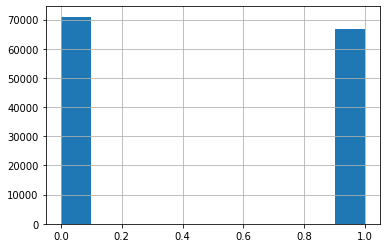

In [48]:
# What if I look at the 2 year survival rate? there are only 20k missing
df_trees.loc[df_trees['yr2status'].notnull(),:]['yr2status'].hist()

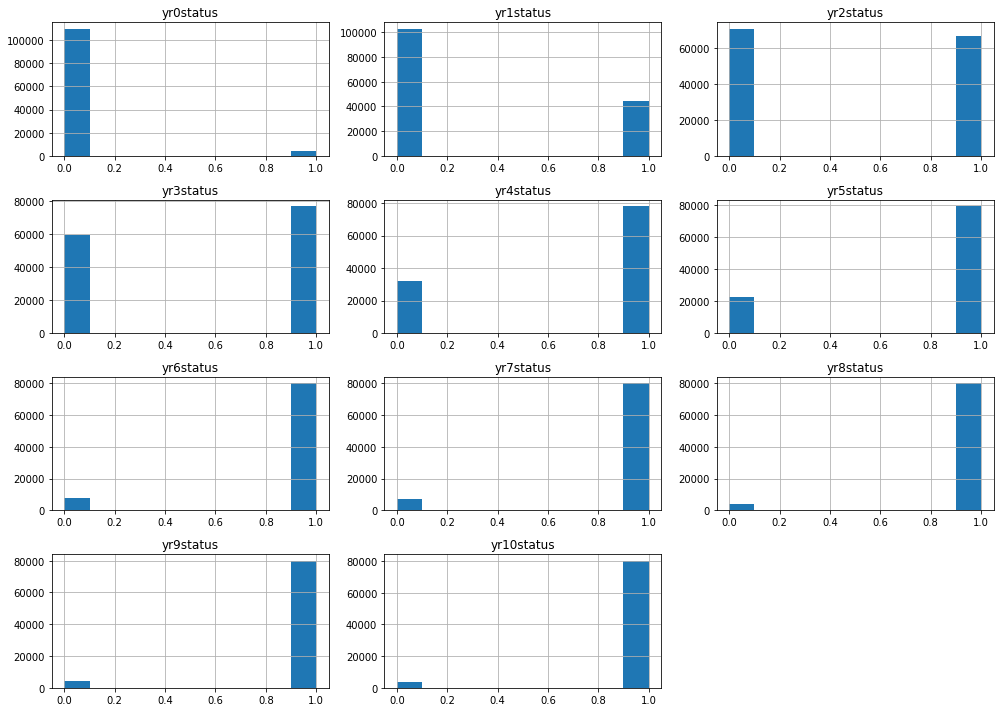

In [53]:
# try to do that programmatically for each year

fig = plt.figure(figsize=(14,10))
for idx,yr in enumerate(features_years):
    ax = fig.add_subplot(4,3,idx+1)
    df_trees.loc[df_trees[yr].notnull(),:][yr].hist(ax=ax)
    ax.set_title(yr)
    
plt.tight_layout();

**Discussion**

- the series of plots makes it look like there are more trees alive at the start, and more trees dead after 10 years, but what's NOT shown is how many NA there are!
- the NaN values mean some trees drop out of the data and others start to show up
- maybe I need to lump them together, e.g. '2 year survival' or something like that

In [55]:
# Reminder of what all we can explore
df_trees.columns

Index(['YrFireName', 'Species', 'Dataset', 'Times_burned', 'ID', 'Plot',
       'TreeNum', 'Unit', 'Genus', 'Species_name', 'Subspecies',
       'Genus_species', 'DBH_cm', 'DRC_cm', 'HT_m', 'HCB_pre', 'CR_pre', 'CC',
       'VR', 'CL_m', 'yr0status', 'yr1status', 'yr2status', 'yr3status',
       'yr4status', 'yr5status', 'yr6status', 'yr7status', 'yr8status',
       'yr9status', 'yr10status', 'HCB_post', 'CR_post', 'CSH_m', 'CLS_m',
       'CLK_m', 'CLS_percent', 'CLK_percent', 'CVS_percent', 'CVK_percent',
       'CVC_percent', 'CBS', 'BCHA_m', 'BCHM_m', 'BCH_percent', 'BCA', 'CKR',
       'GCA', 'GIR_percent', 'DMR', 'BTL', 'AB', 'DFB', 'FEN', 'IPS', 'MPB',
       'RPB', 'RTB', 'SB', 'WPB', 'WB', 'SPB', 'CVS_percent_source',
       'CVK_percent_source'],
      dtype='object')

In [56]:
# Update the number of trees after any drops
num_trees = df_trees.shape[0]

## Distributions of tree data

In [58]:
df_trees['yr0status'].isnull().sum()

54316

In [59]:
df_trees['yr0status'].sum()

3943.0

In [60]:
# look at distributions of trees over the years -- this calculation needs work and
#.  may not make sense until nulls are handled

print(f"Fraction alive year  0: {df_trees['yr0status'].sum()/num_trees:.02f}")
print(f"Fraction alive year  1: {df_trees['yr1status'].sum()/num_trees:.02f}")
print(f"Fraction alive year  2: {df_trees['yr2status'].sum()/num_trees:.02f}")
print(f"Fraction alive year  3: {df_trees['yr3status'].sum()/num_trees:.02f}")
print(f"Fraction alive year  4: {df_trees['yr4status'].sum()/num_trees:.02f}")
print(f"Fraction alive year  5: {df_trees['yr5status'].sum()/num_trees:.02f}")

print(f"Fraction alive year  6: {df_trees['yr6status'].sum()/num_trees:.02f}")
print(f"Fraction alive year  7: {df_trees['yr7status'].sum()/num_trees:.02f}")
print(f"Fraction alive year  8: {df_trees['yr8status'].sum()/num_trees:.02f}")
print(f"Fraction alive year  9: {df_trees['yr9status'].sum()/num_trees:.02f}")
print(f"Fraction alive year 10: {df_trees['yr10status'].sum()/num_trees:.02f}")


Fraction alive year  0: 0.02
Fraction alive year  1: 0.26
Fraction alive year  2: 0.40
Fraction alive year  3: 0.46
Fraction alive year  4: 0.47
Fraction alive year  5: 0.47
Fraction alive year  6: 0.47
Fraction alive year  7: 0.48
Fraction alive year  8: 0.48
Fraction alive year  9: 0.48
Fraction alive year 10: 0.48


In [69]:
# Combine beetles into a single field
def has_beetles(x):
    count = 0
    for btl in features_parasites:
        if (x[btl]==None):
            pass
        elif (x[btl]>0):
            count = 1
    return count

df_trees['fe_beetles'] = df_trees.apply(lambda x: has_beetles(x), axis=1)

In [70]:
df_trees['fe_beetles'].sum()

16548

In [104]:
# Parasites included version
df_trees_partial = df_trees[features_key+features_years+['fe_beetles']].dropna(axis=0)

In [105]:
df_trees_partial.shape

(27878, 14)

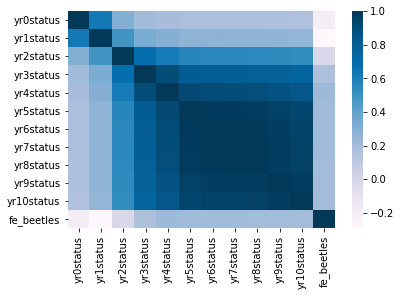

In [106]:
sns.heatmap(df_trees_partial.corr(), cmap='PuBu') # stronger correlation in the later years, but why? dead?

In [107]:
df_trees_partial['yr5status'].sum()

23661.0

(5867, 14)


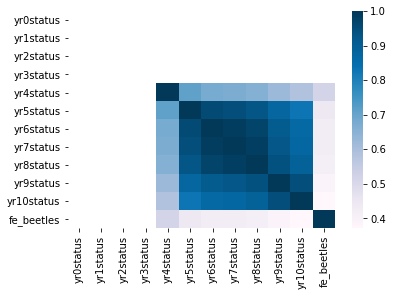

In [108]:
# heatmap alive only
df_trees_partial_alive = df_trees_partial.loc[df_trees_partial['yr3status']==0.0,:]
print(df_trees_partial_alive.shape)
sns.heatmap(df_trees_partial_alive.corr(),cmap='PuBu')

(22011, 14)


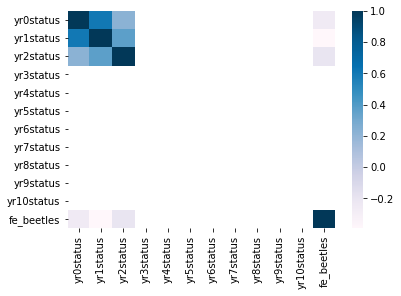

In [109]:
# heatmap dead only
df_trees_partial_alive = df_trees_partial.loc[df_trees_partial['yr3status']==1.0,:]
print(df_trees_partial_alive.shape)
sns.heatmap(df_trees_partial_alive.corr(),cmap='PuBu')

In [115]:
df_trees.columns

Index(['YrFireName', 'Species', 'Dataset', 'Times_burned', 'ID', 'Plot',
       'TreeNum', 'Unit', 'Genus', 'Species_name', 'Subspecies',
       'Genus_species', 'DBH_cm', 'DRC_cm', 'HT_m', 'HCB_pre', 'CR_pre', 'CC',
       'VR', 'CL_m', 'yr0status', 'yr1status', 'yr2status', 'yr3status',
       'yr4status', 'yr5status', 'yr6status', 'yr7status', 'yr8status',
       'yr9status', 'yr10status', 'HCB_post', 'CR_post', 'CSH_m', 'CLS_m',
       'CLK_m', 'CLS_percent', 'CLK_percent', 'CVS_percent', 'CVK_percent',
       'CVC_percent', 'CBS', 'BCHA_m', 'BCHM_m', 'BCH_percent', 'BCA', 'CKR',
       'GCA', 'GIR_percent', 'DMR', 'BTL', 'AB', 'DFB', 'FEN', 'IPS', 'MPB',
       'RPB', 'RTB', 'SB', 'WPB', 'WB', 'SPB', 'CVS_percent_source',
       'CVK_percent_source', 'fe_beetles'],
      dtype='object')

<Figure size 1080x1080 with 0 Axes>

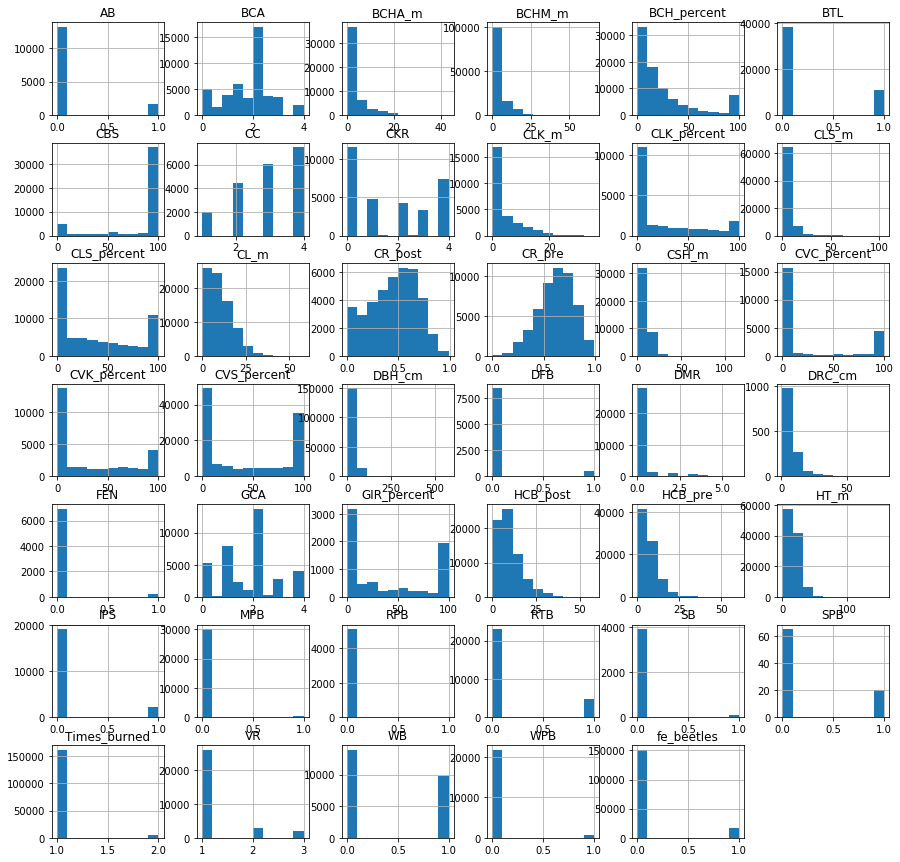

In [116]:
# Alive/Dead, while it seems like an obvious result to predict, may be problematic 
# what else is in here?
features_not_years = ['YrFireName', 'Species', 'Dataset', 'Times_burned', 'ID', 'Plot',
       'TreeNum', 'Unit', 'Genus', 'Species_name', 'Subspecies',
       'Genus_species', 'DBH_cm', 'DRC_cm', 'HT_m', 'HCB_pre', 'CR_pre', 'CC',
       'VR', 'CL_m', 'HCB_post', 'CR_post', 'CSH_m', 'CLS_m',
       'CLK_m', 'CLS_percent', 'CLK_percent', 'CVS_percent', 'CVK_percent',
       'CVC_percent', 'CBS', 'BCHA_m', 'BCHM_m', 'BCH_percent', 'BCA', 'CKR',
       'GCA', 'GIR_percent', 'DMR', 'BTL', 'AB', 'DFB', 'FEN', 'IPS', 'MPB',
       'RPB', 'RTB', 'SB', 'WPB', 'WB', 'SPB', 'CVS_percent_source',
       'CVK_percent_source', 'fe_beetles']
fig = plt.figure(figsize=(15,15))
df_trees[features_not_years].hist(figsize=(15,15));

In [120]:
#fig = plt.figure(figsize=(15,15))
#df_trees[features_not_years].plot(kind='bar',figsize=(15,15));

## Fires

Data on fires is in a separate file; an INNER JOIN on YrFireName will link the dataframes.

|Feature|Description|NA means|Notes|
|---|---|---|---|
|YrFireName|Year and name of the fire.|||
|Fire|Name of fire. If the fire is in the Monitoring Trends in Burn Severity database, the MTBS exact name was used.|||
|Dataset|The name of the subset(s) of data that was contributed to the Fire and Tree Mortality (FTM) project. This is typically the name of the person who contributed the data to the FTM project but may be the agency that is the primary data steward.|||
|N|The number of trees sampled in each fire-dataset combination.|||
|yr_fire|year of fire|||
|Latitude|Latiude. All location is to the scale of a fire event. If tree or plot coordinates were provided, we took the average of those coordinates to provide one coordinate for the fire event. If a fire name and year was provided, and no coordinates were provided, then we searched the Monitoring Trends in Burn Severity database (Monitoring Trends in Burn Severity 2019) for the fire, downloaded the fire geospatial data, and used the coordinates of the centroid of the fire perimeter for this analysis.|||
|Longitude|Longitude. All location is to the scale of a fire event. If tree or plot coordinates were provided, we took the average of those coordinates to provide one coordinate for the fire event. If a fire name and year was provided, and no coordinates were provided, then we searched the Monitoring Trends in Burn Severity database (Monitoring Trends in Burn Severity 2019) for the fire, downloaded the fire geospatial data, and used the coordinates of the centroid of the fire perimeter for this analysis.|||
|Elevation|Elevation of the geographic coordinates in meters.|||
|month_fire|Numeric month fire started.|NA = not assessed.|
|day_fire|Numeric day fire started.|NA = not assessed.|||
|Fire_type|Type of fire (PNF = prescribed natural fire, or wildland fire use fire; a fire allowed to burn for resource benefit. For prescribed fires that escaped containment, we recorded whether fire was prescribed fire or wildfire at time the plot burned. RX = prescribed fire. Wild = wildfire).|NA = not assessed.||
|State|Name of the state where the fire occurred.|||
|Sample_design|Sampling design (Fixed-area plot = all trees larger than or equal to a specified diameter threshold were sampled in a fixed-area plot; Individual tree = individual trees were sampled independently and not in a plot; Individual trees within plots = a certain number of trees were sampled within each plot; Nested fixed-area plot = trees in different diameter groups were sampled in different sized plots in the same location, typically larger trees in a larger plot and smaller trees in a smaller nested subplot; not available = sample design information was not available; Variable radius plot = all trees within the variable radius plot of the specified basal area factor were sampled in a plot)||
|Plot_size_ha|Values vary based on sample design. For fixed-area plots this field is the size of plot in hectares. Fixed-area plots also include studies where multiple smaller plots were used, but plot identification is only available for groups of pots and the same threshold diameter was used. In these cases we listed the total combined area of those plots and note the sample design. Individual tree sample design = NA. For individual trees within plots, this field contains text description of sampling methods. For nested fixed-area plots, multiple plot sizes are listed with the larger plot size listed first. For variable radius plots the metric BAF (Basal Area Factor) is listed and “BAF” is written after value to specify.|Not available = information was not available.|
|Threshold_diameter_cm|Values vary based on sample design. For plot-based studies, this is the minimum DBH (cm) of trees measured on the plot. For nested fixed-area plots, multiple values are listed, with the larger minimum DBH (cm) listed first, corresponding to the larger plot size. Not available = information was not available.|For individual tree = NA.|
|Study_purpose|The original purpose(s) of the contributed dataset. Studies may have been conducted for multiple purposes. Multiple purpose are separated by semicolon. Purposes include: Carbon Emissions; Fire Effects; Fire-insect Interactions; Fire-insect-disease Interactions; Forest Dynamics; Fuel Treatment Effects; Landscape variability; Remote Sensing; Tree Mortality; Tree Physiology; and Wildlife Response.||

"Questions" is listed as an attribute in the metadata file with definition "Questions regarding data concerns or other comments."

In [121]:
df_fires.columns

Index(['YrFireName', 'Fire', 'Dataset', 'N', 'yr_fire', 'Latitude',
       'Longitude', 'Elevation', 'month_fire', 'day_fire', 'Fire_type',
       'State', 'Sample_design', 'Plot_size_ha', 'Threshold_diameter_cm',
       'Study_purpose'],
      dtype='object')

In [122]:
df_fires.head(3)

,YrFireName,Fire,Dataset,N,yr_fire,Latitude,Longitude,Elevation,month_fire,day_fire,Fire_type,State,Sample_design,Plot_size_ha,Threshold_diameter_cm,Study_purpose
0,1981 - Manning Basin,Manning Basin,Brown,465,1981,42.602739,-111.119003,2028,9.0,22.0,RX,Idaho,Fixed-area plot,0.01815,0 (every tree counted),Fuel Treatment Effects; Tree Mortality
1,1981 - Snowdrift,Snowdrift,Brown,481,1981,42.549037,-111.226913,2860,9.0,22.0,RX,Idaho,Fixed-area plot,0.01815,0 (every tree counted),Fuel Treatment Effects; Tree Mortality
2,1981 - Steep Creek,Steep Creek,Brown,323,1981,42.272226,-110.556666,2368,9.0,28.0,Wild,Wyoming,Fixed-area plot,0.01815,0 (every tree counted),Fuel Treatment Effects; Tree Mortality


In [123]:
df_fires['State'].value_counts()

California        100
Oregon             75
Arizona            63
New Mexico         31
Washington         23
Utah               21
Wyoming            18
Montana            15
Idaho              11
Florida            10
South Carolina      9
South Dakota        9
Colorado            7
Ohio                6
North Carolina      6
Alabama             6
Georgia             2
Alaska              1
Minnesota           1
Arkansas            1
Michigan            1
Name: State, dtype: int64

# 4. Explore secondary data sets

# 5. Summary

## Identify the data types you are working with

- FTM: See the data dictionaries; mix of numerical(float) and categorical(object).

## Examing the distributions of your data, numerically and/or visually

## Identify outliers

- 

## Identify missing data and look for patterns of missing data
- FTM: Missing TreeNum values -- might be a mishap with the Id, Plot, TreeNum text split
- FTM: Some trees are listed as  ...unknown.......dead....  making it difficult to know when they died
- FTM: Some trees are listed as  ...alive.......unknown...  making it difficult to know if they died in the 10 yrs
- FTM:    ...keeping only tree for which the values are filled in for 10 years means there are only 28k left!

- FTM: May need to look to see what the original research was for some of these fires, or may need to get othter sources like satellite images

## Describe how your EDA will inform your modeling decisions and process
- 64 columns of data present already and I want to consider more -- PCA and/or t-SNE may need to considered.
- Missing dead/alive data is critical as it affects the outcome predictions
- Might need to choose something else to predict, such as impact to the crown given the type of bark

## Roadmap and milestones
 - Mon 22 June - **Capstone checkin #2 EDA + Plan**
   - 0 to 60 in 1 day -- data was published this morning, I found it, capstone revised
   - EDA off to the races
  
 - Mon 29 June
   - tree mortality prediction models -- obviously have to try some kind of DecisionTree
   - classification of tree damage?
   - brainstorm of other data and context info complete, top ideas prioritized
  
 - Weds 1 July - **Capstone checkin #3 Progress update**
   - explore possible innovations
   - explore expansions
  
 - Mon 06 July 
   - wind up the expansions; finalize what makes it into the capstone phase
   - organize & hide the stuff that won't finish
   - start writing reports
   
 - Thu 09 July - **Capstone checkin #4 Report writeup**
   - report should be well under way
   
 - Mon 13 July     
   - repo ready
   
 - Weds 15 July - **Capstone checkin #5 Presentation**

In [124]:
print("EDA finished.")

EDA finished.
